# Math 170 - Homework 8, Parth Desai


## Setup

In [ ]:
%pip install numpy jax jaxlib matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
from jax import jit, lax, random, value_and_grad, vmap, grad
import jax.numpy.linalg as jla
import jax.numpy as jnp
from tqdm import tqdm
import matplotlib.pyplot as plt
key = random.PRNGKey(0)

## Question 1

### We have **Gradient Descent**

In [4]:
def gradient_descent(fgradf, x0, eta, T):

    x = x0
    xhist = [] # iterate history
    fhist = [] # objective history
    reshist = [] # gradient norm history

    # main loop
    for t in range(0,T+1):
        fx, gradfx = fgradf(x)
        xhist.append(x)
        fhist.append(fx)
        reshist.append(jla.norm(gradfx))
        x = x - eta * gradfx
    xhist = jnp.asarray(xhist)
    fhist = jnp.asarray(fhist)
    reshist = jnp.asarray(reshist)

    return xhist, fhist, reshist

$\text{We now want to implement }\textbf{Gradient Descent with Backtracking Line Search}$

In [5]:
def gradient_descent_backtrack(f, x0, eta00, tau, gamma, T):
    gradf = grad(f)
    eta = eta00
    x = x0
    xhist = [] # iterate history
    fhist = [] # objective history
    gradhist = [] # gradient norm history
    etahist = [] # step size history
    for _ in tqdm(range(T+1)):
        fx, gradfx = f(x), gradf(x)
        xhist.append(x)
        fhist.append(fx)
        gradhist.append(jla.norm(gradfx))
        etahist.append(eta)
        while f(x - eta*gradfx) > fx - (eta * 0.5 * jla.norm(gradfx)**2):
            eta *= tau
        x = x - eta * gradfx
        eta *= gamma
    xhist = jnp.asarray(xhist)
    fhist = jnp.asarray(fhist)
    gradhist = jnp.asarray(gradhist)
    etahist = jnp.asarray(etahist)
    return xhist, fhist, gradhist, etahist


$\text{Experiment Block}$

In [6]:
# objective function
@jit
def f(x):
    return x[0]**2 - x[0] + 3*x[1]**2 + x[1]

# this creates a joint evaluator for function and gradient
fgradf = jit(value_and_grad(f))

# Batched Evaluator for f
f_batch = vmap(f)

# hyperparameters
T = 100
eta00 = 0.3
tau = 0.5
gamma = 1.2
key, subkey = random.split(key) # careful about RNG in JAX!
x0 = random.normal(subkey,(2,))

# run gradient descent
xhist, fhist, reshist = gradient_descent(fgradf, x0, eta00, T)
xhist_bsl, fhist_bsl, gradhist_bsl, etahist_bsl = gradient_descent_backtrack(f, x0, eta00, tau, gamma, T)


100%|██████████| 101/101 [00:00<00:00, 421.70it/s]


### Plotting for Gradient Descent vs. Gradient Descent with Backtracking Line Search

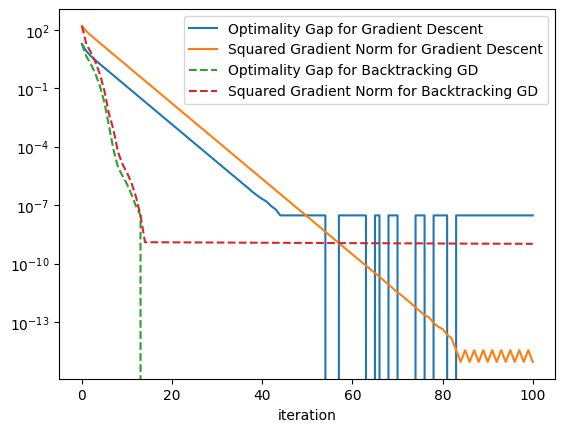

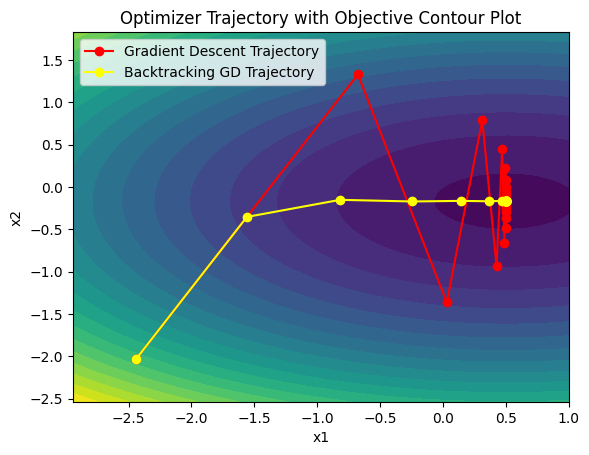

In [7]:
# plot optimality gap (optimal value is -1/3) and gradient norm
plt.semilogy(fhist + 1/3)
plt.semilogy(reshist**2)
plt.semilogy(fhist_bsl + 1/3, '--')
plt.semilogy(gradhist_bsl**2, '--')
plt.legend(["Optimality Gap for Gradient Descent", "Squared Gradient Norm for Gradient Descent", "Optimality Gap for Backtracking GD", "Squared Gradient Norm for Backtracking GD"])
plt.xlabel("iteration")
plt.show()
print("")

# create a grid for objective contour plot
x_range = jnp.linspace(jnp.min(xhist[:,0]) - .5, jnp.max(xhist[:,0]) + .5, 50)
y_range = jnp.linspace(jnp.min(xhist[:,1]) - .5, jnp.max(xhist[:,1]) + .5, 50)
X, Y = jnp.meshgrid(x_range, y_range)

# batched evaluation
xy = jnp.vstack((jnp.ravel(X), jnp.ravel(Y) )).T
Z = jnp.reshape(f_batch(xy), X.shape)

# loop for evaluating f to construct contours, you can check that it's slower
#Z = jnp.array([[f(jnp.array([x, y])) for x in x_range] for y in y_range])

# plot the contour plot
plt.contourf(X, Y, Z, levels=20)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Objective Function Contour Plot")

# plot the optimizer trajectory on top
plt.plot(xhist[:,0], xhist[:,1], '-o', color='red')
plt.plot(xhist_bsl[:,0], xhist_bsl[:,1], '-o', color='yellow')
plt.legend(["Gradient Descent Trajectory", "Backtracking GD Trajectory"])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Optimizer Trajectory with Objective Contour Plot")

plt.show()

As we can see, Backtracking Line Search is able to get higher precision in fewer iterations than simple gradient descent

## Question 2

$\text{We have }\textbf{Gradient Descent with Parameters}$

In [8]:
def gd_params(fgradf, params0, eta, T):

    params = params0
    fhist = [] # objective history
    reshist = [] # gradient norm history

    # main loop
    for t in range(0,T+1):
        val, grads = fgradf(params)
        fhist.append(val)
        tmp = 0
        newparams = []
        for i in range(len(params)):
            newparams.append( params[i] - eta * grads[i] )
            tmp += jla.norm(grads[i])**2
        params = tuple(newparams)
        reshist.append(jnp.sqrt(tmp))
    fhist = jnp.asarray(fhist)
    reshist = jnp.asarray(reshist)

    # return final parameters as well as objective and gradient norm history
    return params, fhist, reshist

$\text{We now want to implement }\textbf{Gradient Descent with Backtracking Line Search for Arbitrary Paramters}$

In [20]:
import jax.tree_util as jtu
import jax.tree
import jax
def take_backstep(p, g, eta):
            return p - eta * g

def gd_params_backtrack(f, params0, eta00, tau, gamma, T):
    gradf = grad(f)
    params = params0
    fhist = [] # objective history
    gradhist = [] # gradient norm history
    etahist = [] # step size history
    eta = eta00
    # main loop
    for _ in tqdm(range(0,T+1)):
        val, grads = f(params), gradf(params)
        grad_norm = jnp.sqrt(sum(jnp.sum(g**2) for g in jtu.tree_leaves(grads)))
        fhist.append(val)
        gradhist.append(grad_norm)
        etahist.append(eta)
        newparams = jtu.tree_map(lambda p, g: take_backstep(p, g, eta), params, grads)
        while f(newparams) > val - (eta * 0.5 * grad_norm**2):
                eta *= tau
                newparams = jtu.tree_map(lambda p, g: take_backstep(p, g, eta), params, grads)
        params = newparams
        # gradhist.append(jnp.sqrt(grads))
    fhist = jnp.asarray(fhist)
    gradhist = jnp.asarray(gradhist)

    # return final parameters as well as objective and gradient norm history
    return params, fhist, gradhist

$\text{Experiment Block}$

100%|██████████| 1001/1001 [00:01<00:00, 647.08it/s]


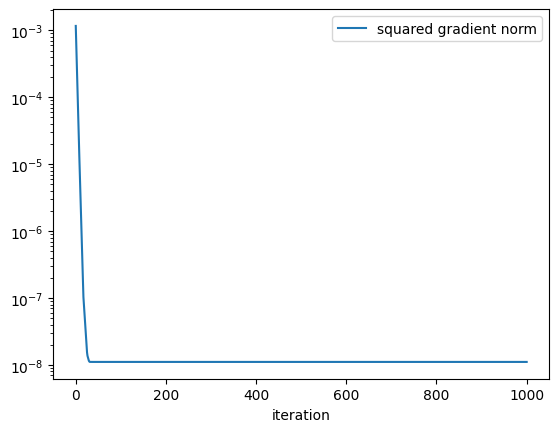

In [25]:
N = 400
n = 2
K = 2

# Generate synthetic data
key = jax.random.PRNGKey(0)
X = jax.random.normal(key, (N, n))     # (400, 2)
Y = jax.random.randint(key, (N,), 0, K)
E = jax.nn.one_hot(Y, K)               # (400, 2)

@jit
def lossterm(x, ey, params):
    W, b = params
    return -jnp.dot(ey, jax.nn.log_softmax(W @ x + b))

lossterm_batch = jit(vmap(lossterm, in_axes=(0, 0, None)))

@jit
def f(params):
    return jnp.mean(lossterm_batch(X, E, params))

# hyperparameters
W = jnp.zeros((K,n))
b = jnp.zeros((K,))
params0 = W,b # intitial guess
T = 1000
eta00 = .5

# run gradient descent
params_bk, fhist_bk, gradhist_bk = gd_params_backtrack(f, params0, eta00, tau, gamma, T)

plt.semilogy(gradhist_bk**2)
plt.legend(["squared gradient norm"])
plt.xlabel("iteration")
plt.show()

With backtracking, the error is far greater than without backtracking

$\text{Contour Plot}$

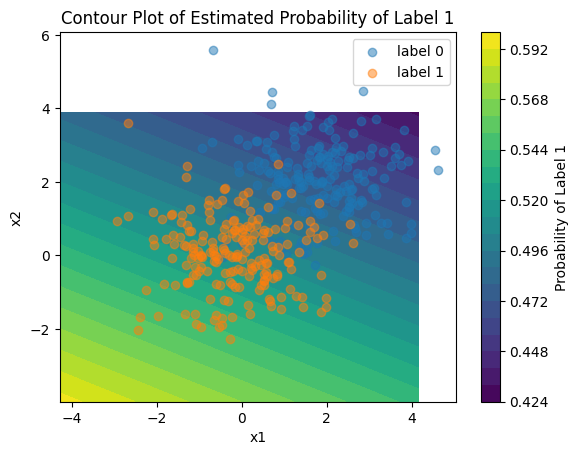

In [23]:
label = 1
X0 = random.normal(subkey, (N//2,2)) + jnp.array([2,2])
X1 = random.normal(subkey, (N - N//2,2))
@jit
def predict_probvec(x, params):
    W, b = params
    probvec = jax.nn.softmax(W @ x + b)
    return probvec

# create a grid for the contour plot
x_range = jnp.linspace(jnp.min(X[:,0]) - 1, jnp.max(X[:,0]) + 1, 100)
y_range = jnp.linspace(jnp.min(X[:,1]) - 1, jnp.max(X[:,1]) + 1, 100)
X_grid, Y_grid = jnp.meshgrid(x_range, y_range)
xy = jnp.vstack((jnp.ravel(X_grid), jnp.ravel(Y_grid) )).T
probvecs = vmap(predict_probvec, in_axes = (0,None) )(xy,params_bk)
Z_prob = jnp.reshape( probvecs[:,label], X_grid.shape )

# plot the contour plot of the probability of label 1
plt.contourf(X_grid, Y_grid, Z_prob, levels=20, cmap='viridis')
plt.colorbar(label='Probability of Label 1')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Contour Plot of Estimated Probability of Label " + str(label))

# Plot the training data on top
plt.scatter(X0[:,0], X0[:,1], label="label 0", alpha=0.5)
plt.scatter(X1[:,0], X1[:,1], label="label 1", alpha=0.5)
plt.legend()

plt.show()

## Question 3

We have **Gradient Descent with Parameters**

In [ ]:
def gd_params(fgradf, params0, eta, T):
    params = params0
    fhist = [] # objective history
    reshist = [] # gradient norm history

    # main loop
    for t in range(0,T+1):
        val, grads = fgradf(params)
        fhist.append(val)
        tmp = 0
        newparams = []
        for i in range(len(params)):
            newparams.append( params[i] - eta * grads[i] )
            tmp += jla.norm(grads[i])**2
        params = tuple(newparams)
        reshist.append(jnp.sqrt(tmp))
    fhist = jnp.asarray(fhist)
    reshist = jnp.asarray(reshist)

    # return final parameters as well as objective and gradient norm history
    return params, fhist, reshist

We now implement **Nesterov's Acceleration**

In [47]:
def gd_params_nesterov(fgradf, params0, eta, T):
    params = params0
    v = tuple(jnp.zeros_like(p) for p in params)
    fhist = [] # objective history
    gradhist = [] # gradient norm history

    # main loop
    for t in tqdm(range(0,T+1)):
        mu = t/(t+3)
        y = tuple(params[i] + mu * v[i] for i in range(len(params)))
        val, grads = fgradf(y)
        fhist.append(val)
        gradnorm = sum([jla.norm(g)**2 for g in grads])
        gradhist.append(jnp.sqrt(gradnorm))
        v_update = []
        newparams = []
        for i in range(len(params)):
            v_i = (mu * v[i])  - (eta*grads[i])
            p_i = params[i] + v_i
            v_update.append(v_i)
            newparams.append(p_i)
        params = tuple(newparams)
        v = tuple(v_update)
    fhist = jnp.asarray(fhist)
    gradhist = jnp.asarray(gradhist)

    # return final parameters as well as objective and gradient norm history
    return params, fhist, gradhist

### $\text{Experiment Block}$

  0%|          | 0/1001 [00:00<?, ?it/s]

100%|██████████| 1001/1001 [00:00<00:00, 2480.12it/s]


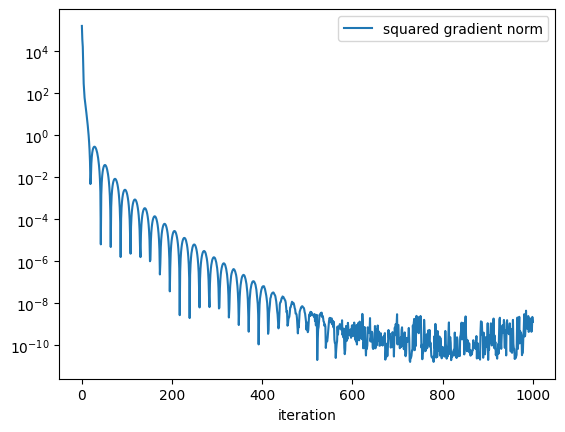

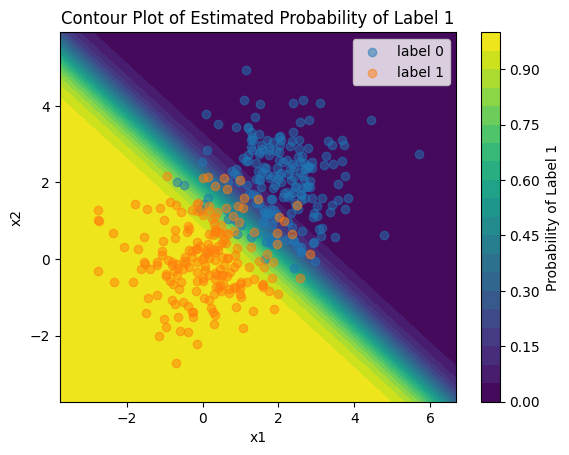

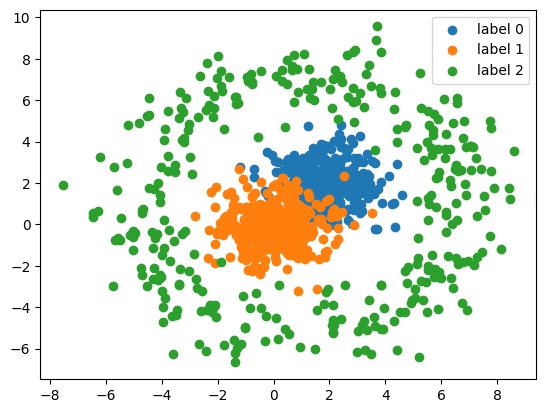

In [48]:
m = 1000
n = 30
gamma = 0.05

# random measurement matrix of roughly unit spectral norm
key, subkey = random.split(key)
A = random.normal(subkey, (m, n)) / (jnp.sqrt(m) + jnp.sqrt(n))

# random noise vector of roughly norm gamma
key, subkey = random.split(key)
noise = gamma * random.normal(subkey, (m,)) / jnp.sqrt(m)

# "ground truth" of roughly unit norm
key, subkey = random.split(key)
xtrue = random.normal(subkey, (n,)) / jnp.sqrt(n)

# generate noisy measurements
b = A@xtrue + noise

# @jit
# def f(x):
#     return jla.norm(A@x - b)**2
# fgradf = jit(value_and_grad(f))
# f_batch = vmap(f)


N = 400
n = 2 # data lives in dimension 2
K = 2 # two classes

# create training data

# 0 labels generated from gaussian with mean (2,2)
key, subkey = random.split(key)
X0 = random.normal(subkey, (N//2,2)) + jnp.array([2,2])
Y0 = jnp.zeros((N//2,1))

# 1 labels generated from gaussian with mean (0,0)
key, subkey = random.split(key)
X1 = random.normal(subkey, (N - N//2,2))
Y1 = jnp.ones((N - N//2,1))

# combine into training data
X = jnp.vstack((X0,X1))
Y = jnp.vstack((Y0,Y1))

# # plot training data
# plt.scatter(X0[:,0], X0[:,1], label="label 0", alpha = 0.5)
# plt.scatter(X1[:,0], X1[:,1], label="label 1", alpha = 0.5)
# plt.legend()

# we are now given X, Y (dataset)

# create one-hot encoding
E = jax.nn.one_hot(Y,K)

# we will think of params = (W,b) as a tuple of parameters to be optimized

# build loss for one data point
@jit
def lossterm(x,ey,params):
    W,b = params
    return -jnp.dot(ey,jax.nn.log_softmax(W@x + b))

# batch across the dataset
lossterm_batch = jit(vmap(lossterm,in_axes=(0,0,None)))

# build objective, now treating X and E (dataset) as constant
@jit
def f(params):
    return jnp.mean( jnp.sum(lossterm_batch(X,E,params)) )

# JAX can do automatic differentiation with respect to tuple of inputs
fgradf = jit(value_and_grad(f))


# hyperparameters
W = jnp.zeros((K,n))
b = jnp.zeros((K,))
params0 = W,b # intitial guess
T = 1000
eta = .005

# run gradient descent
params, fhist, reshist = gd_params_nesterov(fgradf, params0, eta, T)

plt.semilogy(reshist**2)
plt.legend(["squared gradient norm"])
plt.xlabel("iteration")
plt.show()

label = 1

@jit
def predict_probvec(x, params):
    W, b = params
    probvec = jax.nn.softmax(W @ x + b)
    return probvec

# create a grid for the contour plot
x_range = jnp.linspace(jnp.min(X[:,0]) - 1, jnp.max(X[:,0]) + 1, 100)
y_range = jnp.linspace(jnp.min(X[:,1]) - 1, jnp.max(X[:,1]) + 1, 100)
X_grid, Y_grid = jnp.meshgrid(x_range, y_range)
xy = jnp.vstack((jnp.ravel(X_grid), jnp.ravel(Y_grid) )).T
probvecs = vmap(predict_probvec, in_axes = (0,None) )(xy,params)
Z_prob = jnp.reshape( probvecs[:,label], X_grid.shape )

# plot the contour plot of the probability of label 1
plt.contourf(X_grid, Y_grid, Z_prob, levels=20, cmap='viridis')
plt.colorbar(label='Probability of Label 1')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Contour Plot of Estimated Probability of Label " + str(label))

# Plot the training data on top
plt.scatter(X0[:,0], X0[:,1], label="label 0", alpha=0.5)
plt.scatter(X1[:,0], X1[:,1], label="label 1", alpha=0.5)
plt.legend()

plt.show()

N = 1000

# Create training data

n = 2 # data lives in dimension 2
K = 3 # two classes

# 0 labels generated from gaussian with mean (2,2)
key, subkey = random.split(key)
X0 = random.normal(subkey, (N//3,2)) + jnp.array([2,2])
Y0 = jnp.zeros((N//3,1))

# 1 labels generated from gaussian with mean (0,0)
key, subkey = random.split(key)
X1 = random.normal(subkey, (N//3,2))
Y1 = jnp.ones((N//3,1))

# 2 labels generated randomly from a circle around (1,1) plus gaussian noise
key, subkey = random.split(key)
Theta = 2 * jnp.pi * random.uniform(subkey,(N-2 * (N//3),1))
R = jnp.hstack( (jnp.cos(Theta), jnp.sin(Theta)) )
key, subkey = random.split(key)
X2 = random.normal(subkey, (N-2 * (N//3),2)) + jnp.array([1,1]) + 6*R
Y2 = 2*jnp.ones((N- 2* (N//3),1))

# combine into training data
X = jnp.vstack((X0,X1,X2))
Y = jnp.vstack((Y0,Y1,Y2))

# plot training data
plt.scatter(X0[:,0], X0[:,1], label="label 0")
plt.scatter(X1[:,0], X1[:,1], label="label 1")
plt.scatter(X2[:,0], X2[:,1], label="label 2")
plt.legend()

$\text{Experiment Block 2}$

100%|██████████| 1001/1001 [00:00<00:00, 2697.02it/s]


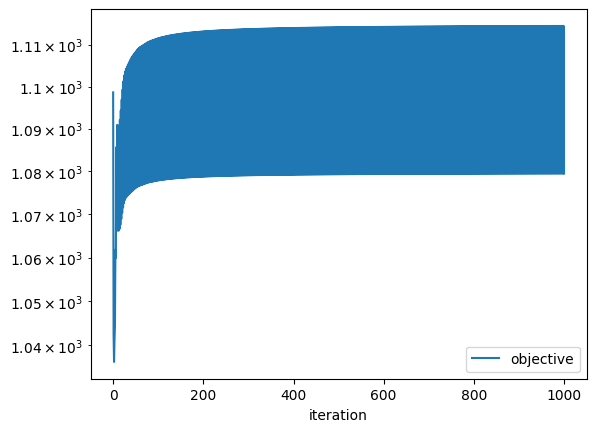

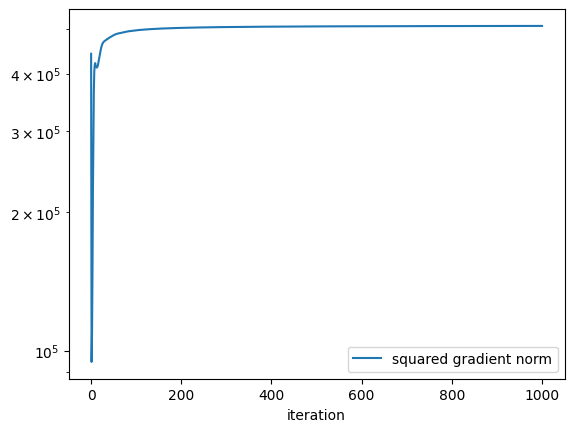

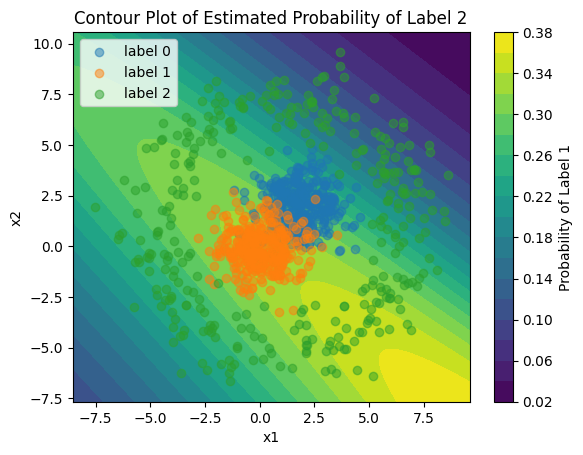

In [49]:
# create one-hot encoding
onehot = jax.nn.one_hot(Y,K)

# we already built lossterm_batch, just need to recompile a new objective with new data
@jit
def f(params):
    return jnp.mean(jnp.sum(lossterm_batch(X,onehot,params)) )
fgradf = jit(value_and_grad(f))

T = 1000
eta = .0004

# hyperparameters
W = jnp.zeros((K,n))
b = jnp.zeros((K,))
params0 = W,b

# run gradient descent
params, fhist, reshist = gd_params_nesterov(fgradf, params0, eta, T)

plt.semilogy(fhist)
plt.legend(["objective"])
plt.xlabel("iteration")
plt.show()
print("")

plt.semilogy(reshist**2)
plt.legend(["squared gradient norm"])
plt.xlabel("iteration")
plt.show()

label = 2

# define predicted probability vector as a function of input
@jit
def predict_probvec(x, params):
    W, b = params
    probvec = jax.nn.softmax(W @ x + b)
    return probvec

# create a grid for the contour plot
x_range = jnp.linspace(jnp.min(X[:,0]) - 1, jnp.max(X[:,0]) + 1, 100)
y_range = jnp.linspace(jnp.min(X[:,1]) - 1, jnp.max(X[:,1]) + 1, 100)
X_grid, Y_grid = jnp.meshgrid(x_range, y_range)
xy = jnp.vstack((jnp.ravel(X_grid), jnp.ravel(Y_grid) )).T
probvecs = vmap(predict_probvec, in_axes = (0,None) )(xy,params)
Z_prob = jnp.reshape( probvecs[:,label], X_grid.shape )

# plot the contour plot of the probability of label 1
plt.contourf(X_grid, Y_grid, Z_prob, levels=20, cmap='viridis')
plt.colorbar(label='Probability of Label 1')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Contour Plot of Estimated Probability of Label " + str(label))

# Plot the training data on top
plt.scatter(X0[:,0], X0[:,1], label="label 0", alpha=0.5)
plt.scatter(X1[:,0], X1[:,1], label="label 1", alpha=0.5)
plt.scatter(X2[:,0], X2[:,1], label="label 2", alpha=0.5)
plt.legend()

plt.show()

$\text{Experiment Block 3}$

100%|██████████| 10001/10001 [00:03<00:00, 2956.71it/s]


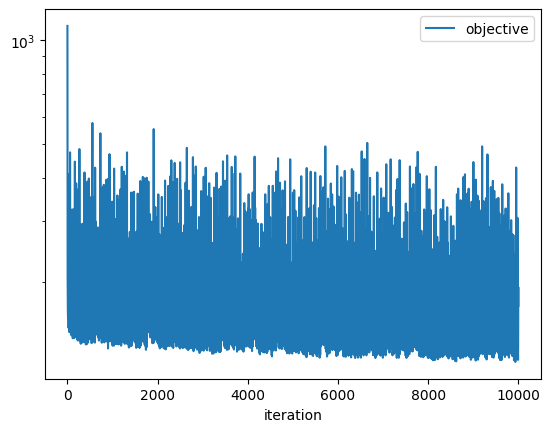

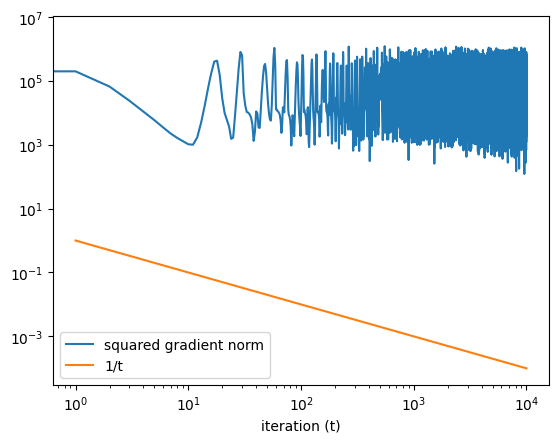

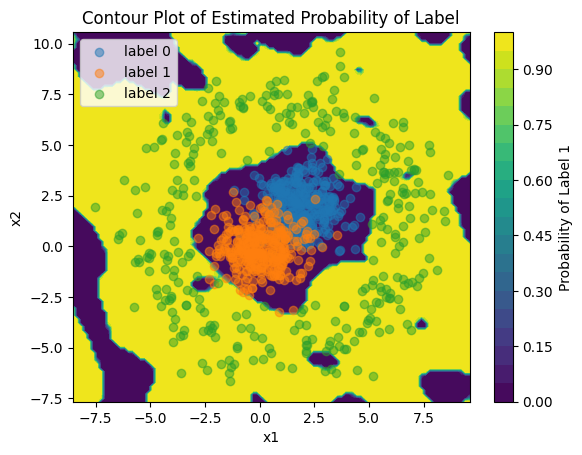

In [50]:
p = 100

# define random Fourier features
key, subkey = random.split(key)
A = .7*random.normal(subkey, (p,n))
key, subkey = random.split(key)
c = 10*random.normal(subkey, (p,))

def feature_map(x):
    return jnp.sin( A@x + c )

# embedded data in higher dimension
XX = vmap(feature_map)(X)

# define objective with new X data
@jit
def f(params):
    return jnp.sum( jnp.sum(lossterm_batch(XX,onehot,params)) )
fgradf = jit(value_and_grad(f))

# hyperparameters
W = jnp.zeros((K,p))
b = jnp.zeros((K,))
params0 = W,b
T = 10000
eta = .0007

# run gradient descent
params, fhist, reshist = gd_params_nesterov(fgradf, params0, eta, T)

plt.semilogy(fhist)
plt.legend(["objective"])
plt.xlabel("iteration")
plt.show()
print("")

plt.loglog(reshist**2)
plt.loglog(1/jnp.arange(T))
plt.legend(["squared gradient norm","1/t"])
plt.xlabel("iteration (t)")
plt.show()

label = 2

# define predicted probability vector as a function of original input space
@jit
def predict_probvec(x, params):
    W, b = params
    probvec = jax.nn.softmax( W@feature_map(x) + b)
    return probvec

# create a grid for the contour plot
x_range = jnp.linspace(jnp.min(X[:,0]) - 1, jnp.max(X[:,0]) + 1, 100)
y_range = jnp.linspace(jnp.min(X[:,1]) - 1, jnp.max(X[:,1]) + 1, 100)
X_grid, Y_grid = jnp.meshgrid(x_range, y_range)
xy = jnp.vstack((jnp.ravel(X_grid), jnp.ravel(Y_grid) )).T
probvecs = vmap(predict_probvec, in_axes = (0,None) )(xy,params)
Z_prob = jnp.reshape( probvecs[:,label], X_grid.shape )

# plot the contour plot of the probability of label 1
plt.contourf(X_grid, Y_grid, Z_prob, levels=20, cmap='viridis')
plt.colorbar(label='Probability of Label 1')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Contour Plot of Estimated Probability of Label")

# Plot the training data on top
plt.scatter(X0[:,0], X0[:,1], label="label 0", alpha=0.5)
plt.scatter(X1[:,0], X1[:,1], label="label 1", alpha=0.5)
plt.scatter(X2[:,0], X2[:,1], label="label 2", alpha=0.5)
plt.legend()

plt.show()

The oscillation with Nesterov's acceleration is very noticeable.

## Question 4

In [59]:
def prox(alpha, y):
    return jnp.sign(y) * jnp.maximum(jnp.abs(y) - alpha, 0.0)

def prox_gradient_descent(fgradf, prox, lam, x0, eta, T):

    x = x0
    xhist = [] # iterate history
    fhist = [] # objective history
    gradhist = [] # gradient norm history

    # main loop
    for _ in tqdm(range(0,T+1)):
        fx, gradfx = fgradf(x)
        xhist.append(x)
        fhist.append(fx)
        gradhist.append(jla.norm(gradfx))
        y = x - eta * gradfx
        x = prox(lam * eta, y)
    xhist = jnp.asarray(xhist)
    fhist = jnp.asarray(fhist)
    gradhist = jnp.asarray(gradhist)

    return xhist, fhist, gradhist


### $\text{Experiment Block}$

100%|██████████| 1001/1001 [00:00<00:00, 2823.44it/s]


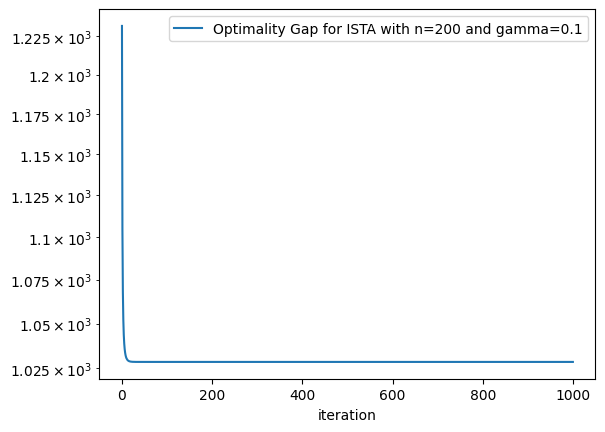

100%|██████████| 1001/1001 [00:00<00:00, 4270.62it/s]


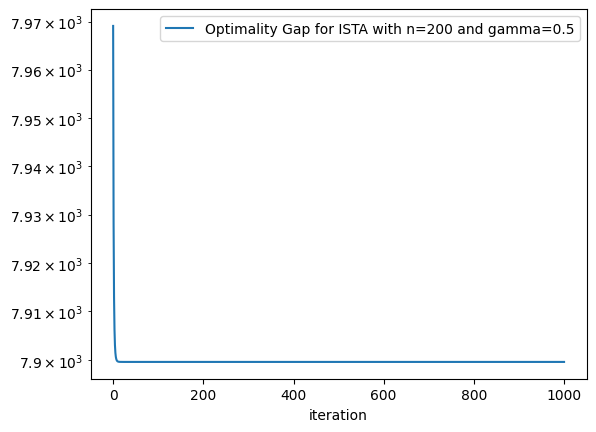

100%|██████████| 1001/1001 [00:00<00:00, 4548.69it/s]


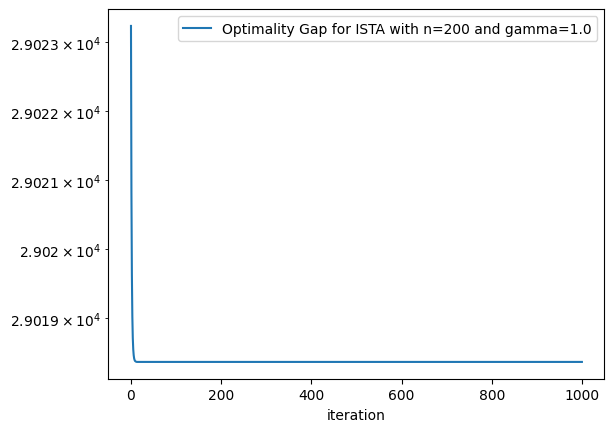

100%|██████████| 1001/1001 [00:00<00:00, 2507.75it/s]


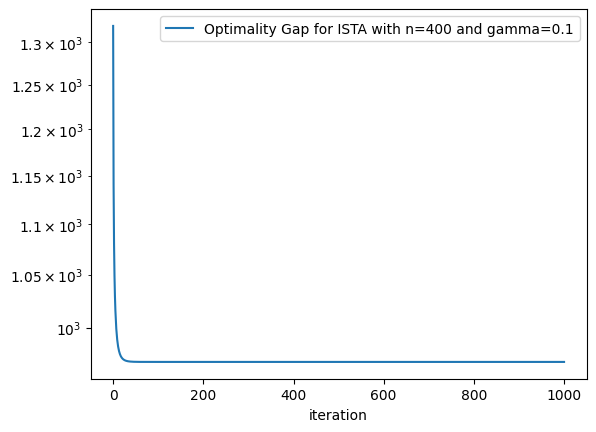

100%|██████████| 1001/1001 [00:00<00:00, 4109.60it/s]


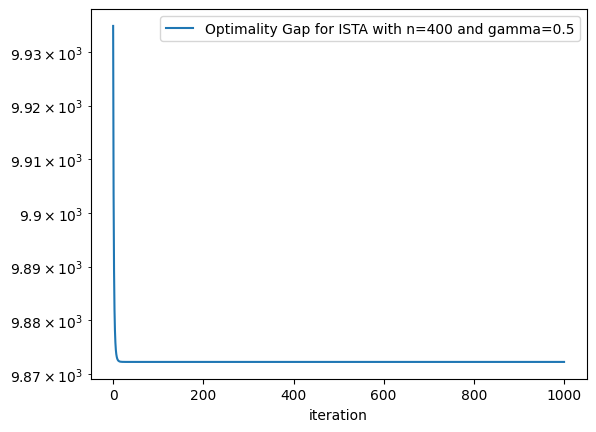

100%|██████████| 1001/1001 [00:00<00:00, 4686.15it/s]


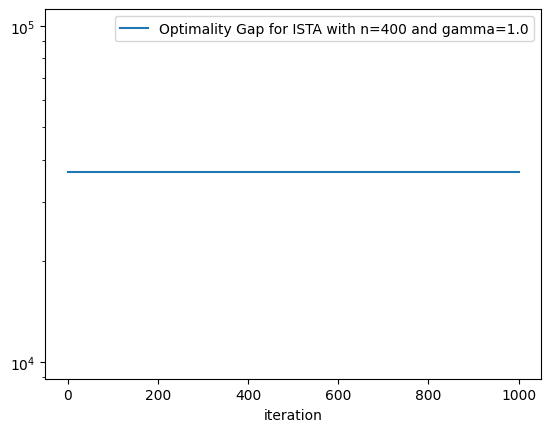

100%|██████████| 1001/1001 [00:00<00:00, 2284.78it/s]


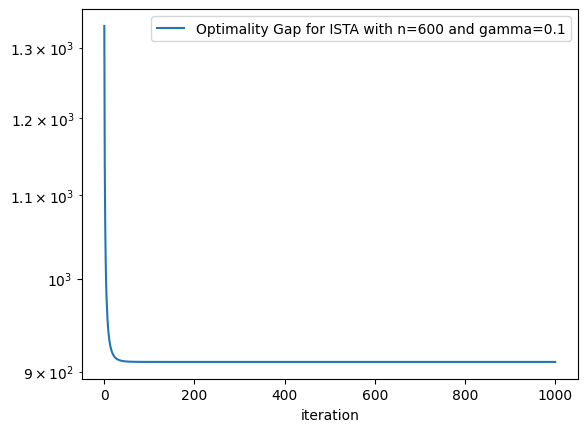

100%|██████████| 1001/1001 [00:00<00:00, 3826.70it/s]


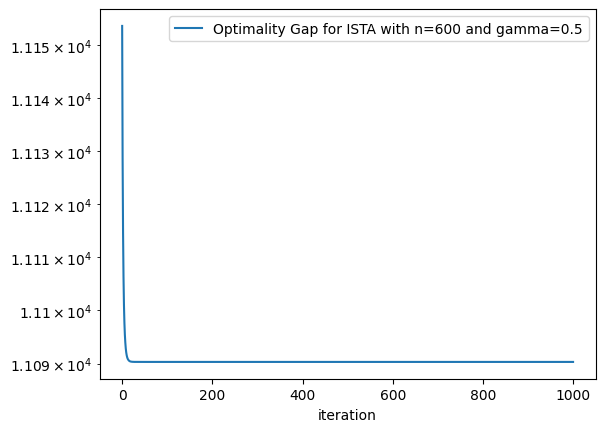

100%|██████████| 1001/1001 [00:00<00:00, 3895.60it/s]


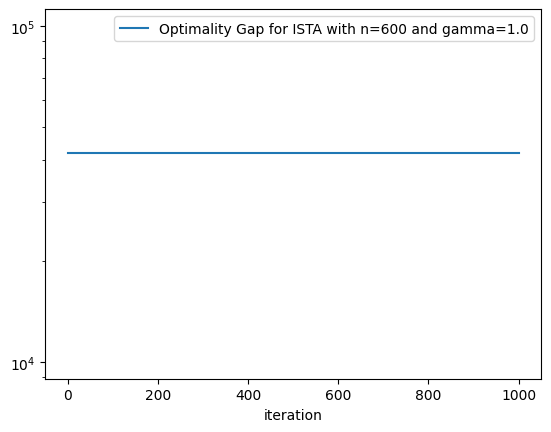

100%|██████████| 1001/1001 [00:00<00:00, 2355.10it/s]


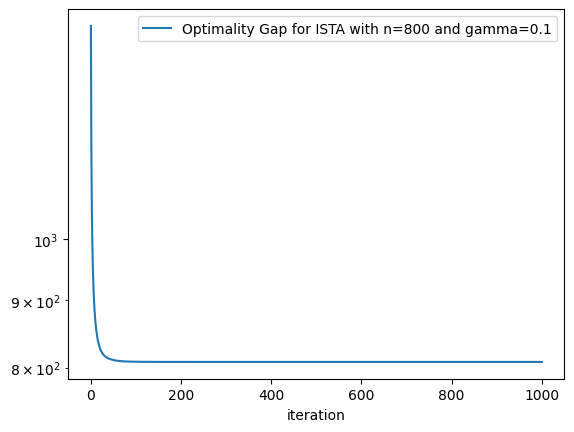

100%|██████████| 1001/1001 [00:00<00:00, 3343.50it/s]


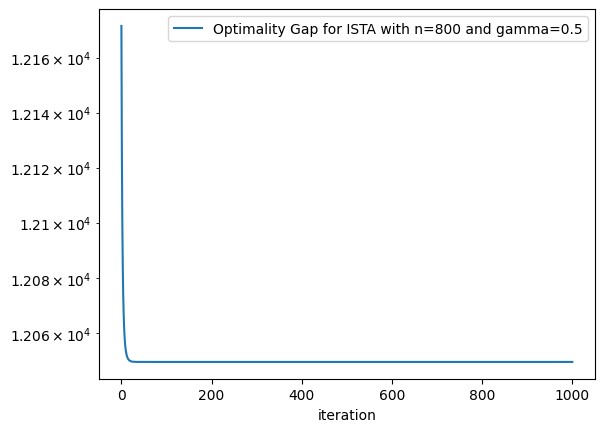

100%|██████████| 1001/1001 [00:00<00:00, 3625.14it/s]


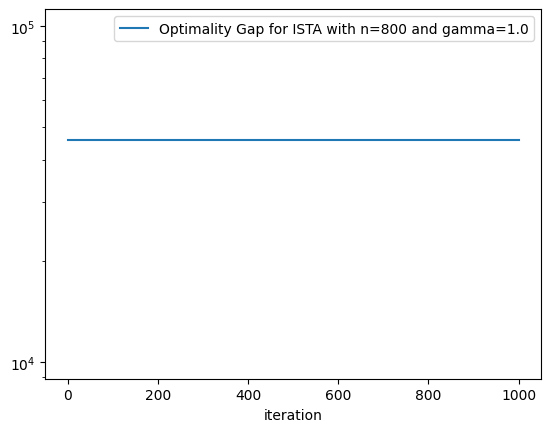

100%|██████████| 1001/1001 [00:00<00:00, 2150.90it/s]


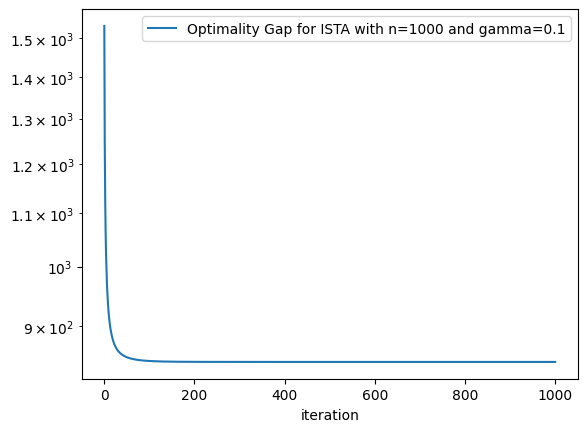

100%|██████████| 1001/1001 [00:00<00:00, 2726.41it/s]


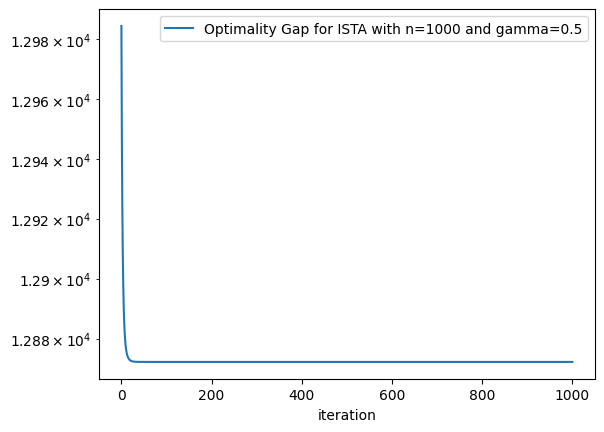

100%|██████████| 1001/1001 [00:00<00:00, 3044.42it/s]


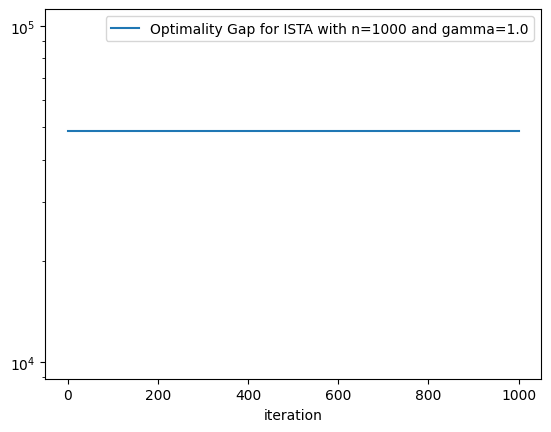

In [62]:
k = 10 
m = 1000 
n = [200, 400, 600, 800, 1000]
gamma = [0.1, 0.5, 1.0]
lambda_ista = []
eta_ista = []
for val in n:
    eta_ista.append(1/(2 * ((jnp.sqrt(m)+jnp.sqrt(val))**2)))
    for g in gamma:
        lambda_ista.append(g*jnp.sqrt(m)*jnp.log(val))

for i in range(len(n)):
    # Build A with correct dimensionality
    A = random.normal(random.PRNGKey(i), (m, n[i]))
    b = random.normal(random.PRNGKey(100+i), (m,))
    
    for j in range(len(gamma)):
        x0 = jnp.zeros((n[i],))
        eta = eta_ista[i]
        lam = lambda_ista[i*3 + j]

        # Re-JIT f and fgradf so they close over the new A
        @jit
        def f(x):
            return jla.norm(A @ x - b)**2

        fgradf = jit(value_and_grad(f))

        # Run ISTA
        xhist_ista, fhist_ista, gradhist_ista = prox_gradient_descent(
            fgradf, prox, lam, x0, eta, 1000
        )

        plt.semilogy(fhist_ista + (gamma[j]**2) * m * (jnp.log(n[i]))**2)
        plt.legend([f"Optimality Gap for ISTA with n={n[i]} and gamma={gamma[j]}"])
        plt.xlabel("iteration")
        plt.show()
        print("")

## Question 5

In [63]:
def prox(alpha, y):
    return jnp.sign(y) * jnp.maximum(jnp.abs(y) - alpha, 0.0)

def prox_gradient_descent(fgradf, prox, lam, x0, eta, T):

    x = x0
    xhist = [] # iterate history
    fhist = [] # objective history
    gradhist = [] # gradient norm history

    # main loop
    for _ in tqdm(range(0,T+1)):
        fx, gradfx = fgradf(x)
        xhist.append(x)
        fhist.append(fx)
        gradhist.append(jla.norm(gradfx))
        while f(x - eta*gradfx) > fx - (eta * 0.5 * jla.norm(gradfx)**2):
            eta *= tau
        y = x - eta * gradfx
        x = prox(lam * eta, y)
    xhist = jnp.asarray(xhist)
    fhist = jnp.asarray(fhist)
    gradhist = jnp.asarray(gradhist)

    return xhist, fhist, gradhist

100%|██████████| 1001/1001 [00:00<00:00, 2659.94it/s]


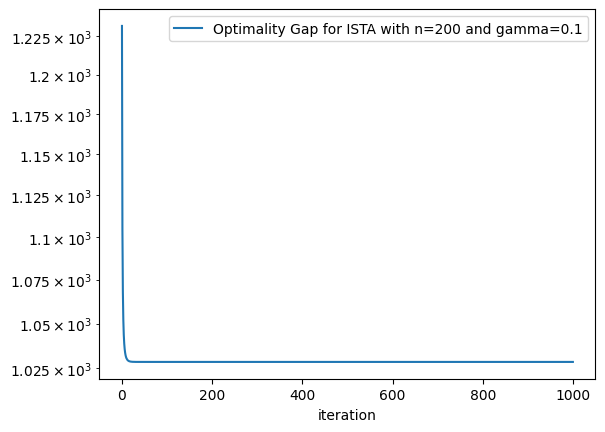

100%|██████████| 1001/1001 [00:00<00:00, 2674.42it/s]


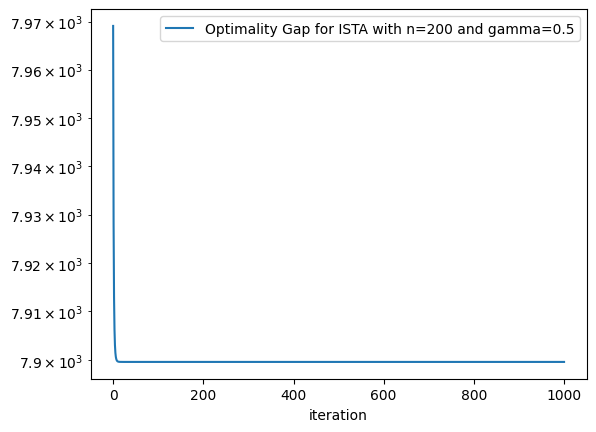

100%|██████████| 1001/1001 [00:00<00:00, 2771.45it/s]


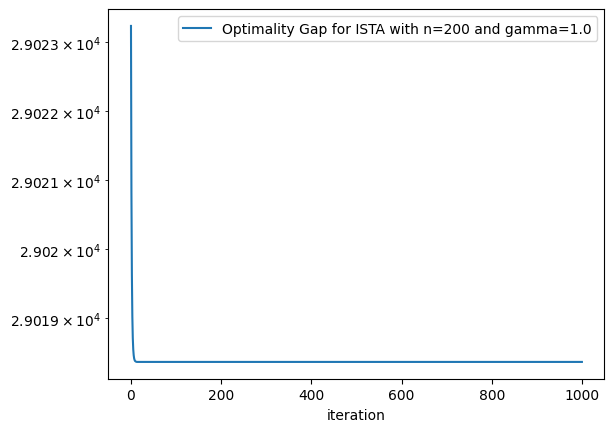

100%|██████████| 1001/1001 [00:00<00:00, 2244.50it/s]


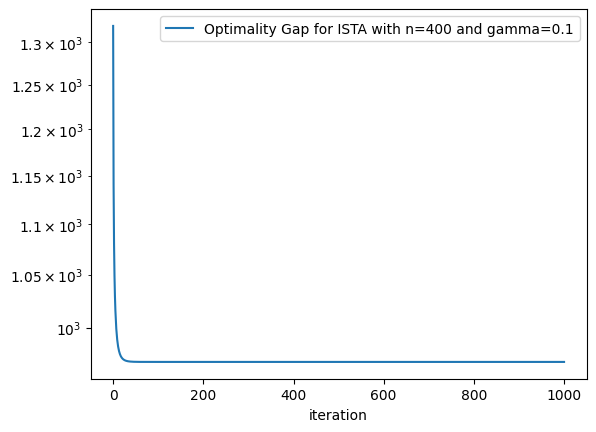

100%|██████████| 1001/1001 [00:00<00:00, 2320.17it/s]


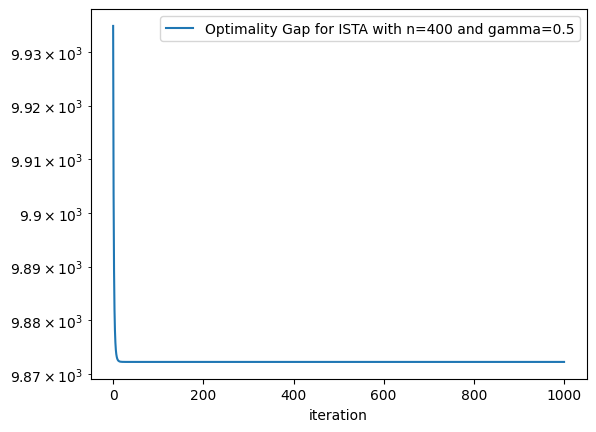

100%|██████████| 1001/1001 [00:00<00:00, 2416.18it/s]


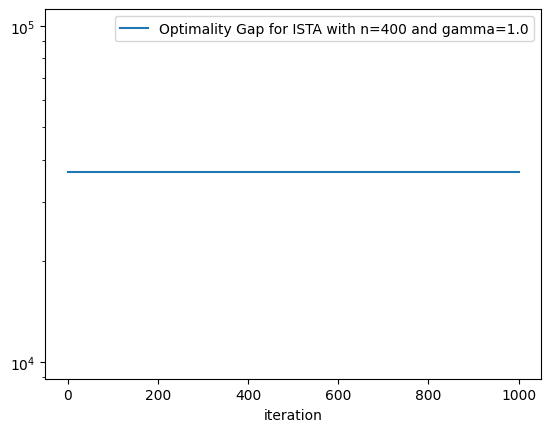

100%|██████████| 1001/1001 [00:00<00:00, 1976.57it/s]


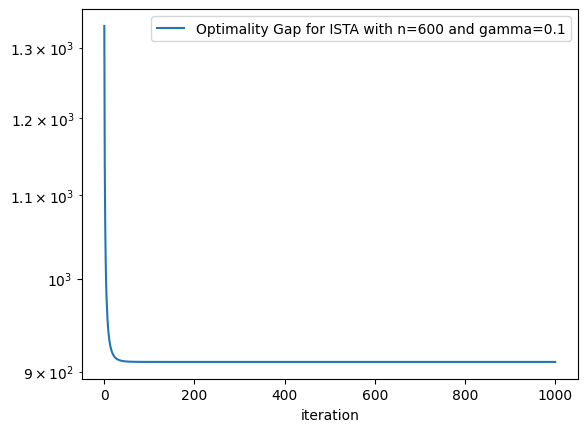

100%|██████████| 1001/1001 [00:00<00:00, 2031.09it/s]


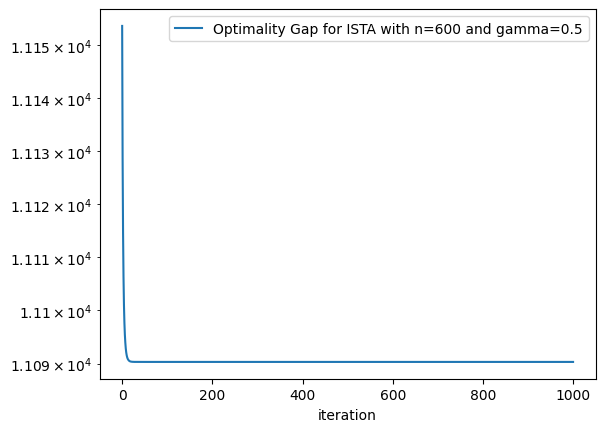

100%|██████████| 1001/1001 [00:00<00:00, 2008.01it/s]


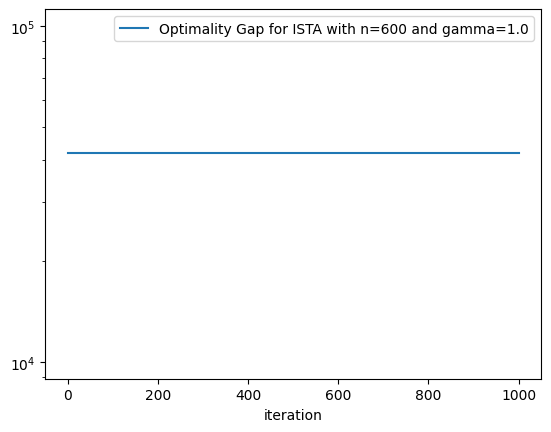

100%|██████████| 1001/1001 [00:00<00:00, 1669.80it/s]


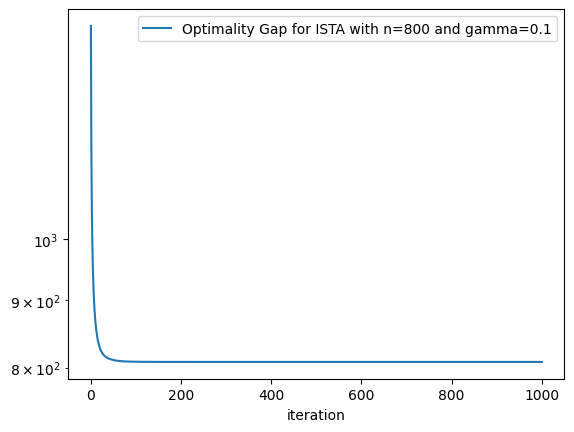

100%|██████████| 1001/1001 [00:00<00:00, 1627.03it/s]


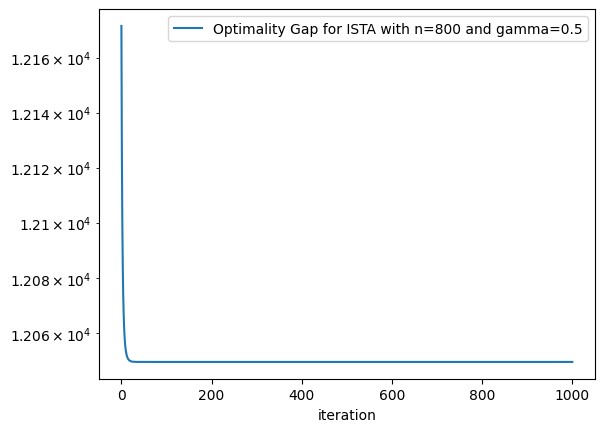

100%|██████████| 1001/1001 [00:00<00:00, 1713.00it/s]


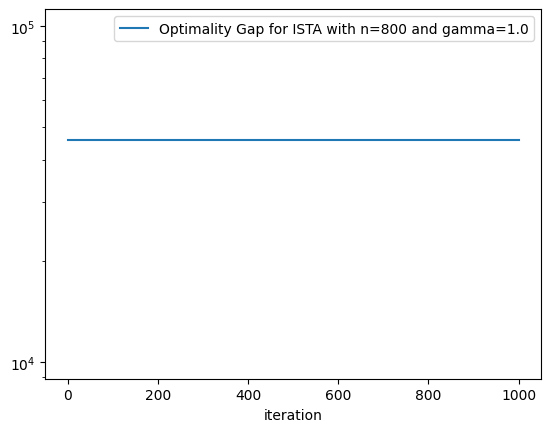

100%|██████████| 1001/1001 [00:00<00:00, 1551.30it/s]


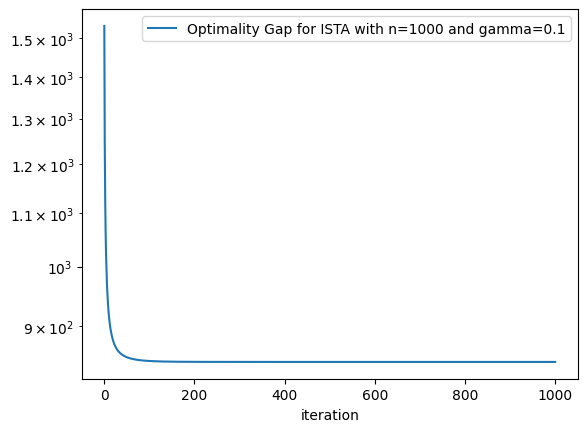

100%|██████████| 1001/1001 [00:00<00:00, 1492.01it/s]


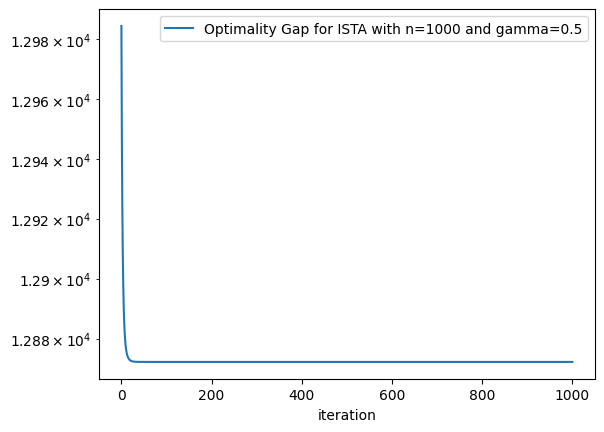

100%|██████████| 1001/1001 [00:00<00:00, 1551.02it/s]


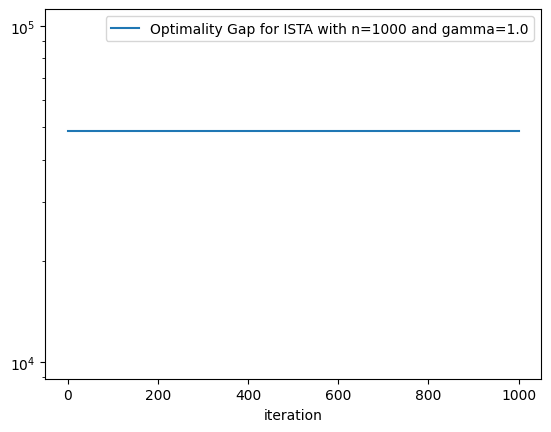

In [64]:
k = 10 
m = 1000 
n = [200, 400, 600, 800, 1000]
gamma = [0.1, 0.5, 1.0]
lambda_ista = []
eta_ista = []
for val in n:
    eta_ista.append(1/(2 * ((jnp.sqrt(m)+jnp.sqrt(val))**2)))
    for g in gamma:
        lambda_ista.append(g*jnp.sqrt(m)*jnp.log(val))

for i in range(len(n)):
    # Build A with correct dimensionality
    A = random.normal(random.PRNGKey(i), (m, n[i]))
    b = random.normal(random.PRNGKey(100+i), (m,))
    
    for j in range(len(gamma)):
        x0 = jnp.zeros((n[i],))
        eta = eta_ista[i]
        lam = lambda_ista[i*3 + j]

        # Re-JIT f and fgradf so they close over the new A
        @jit
        def f(x):
            return jla.norm(A @ x - b)**2

        fgradf = jit(value_and_grad(f))

        # Run ISTA
        xhist_ista, fhist_ista, gradhist_ista = prox_gradient_descent(
            fgradf, prox, lam, x0, eta, 1000
        )

        plt.semilogy(fhist_ista + (gamma[j]**2) * m * (jnp.log(n[i]))**2)
        plt.legend([f"Optimality Gap for ISTA with n={n[i]} and gamma={gamma[j]}"])
        plt.xlabel("iteration")
        plt.show()
        print("")